In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import seaborn as sns

#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('universal_tagset')
#nltk.download('vader_lexicon')

In [2]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
tokenizer.model_max_length = 512

## Tools

In [3]:
def nltkmodel(df):
    res = {}
    sia = SentimentIntensityAnalyzer()
    for i, row in df.iterrows():
        text = row['review']
        myid = i
        res[myid] = sia.polarity_scores(str(text))
    df_res = pd.DataFrame(res).T
    return df_res.merge(df,left_index=True,right_index=True)

In [4]:
def robertaone(example):
    if(type(example) == str):
        encoded_text = tokenizer(example, return_tensors='pt',padding='max_length', truncation=True, max_length=514)
        output = model(**encoded_text)
        scores = output[0][0].detach().numpy()
    else :
        scores[0] = -1
        scores[1] = -1
        scores[2] = -1
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

def robertamodel(df):
    res = {}
    size = df["review"].count()
    j = 0
    m = 0
    for i, row in df.iterrows():
        if(m==50):
            print(f"Status : {(j/size)*100} %", end="\r")
            m = 0
        text = row['review']
        myid = i
        res[myid] = robertaone(text)
        j+=1
        m+=1
    df_res = pd.DataFrame(res).T
    return df_res.merge(df,left_index=True,right_index=True)


# Kayak

In [5]:
kayak = pd.read_csv("kayak.csv")
kayak

,year,rating,review
0,2023,5,It's really mind-blowing how low of the prices...
1,2023,4,I really like the kayak app.. it's great for f...
2,2023,2,The app no longer works for hotel searches. Fo...
3,2022,3,I find Kayak to have the most customizable fli...
4,2021,2,In the past the app has been pretty accurate w...
...,...,...,...
43648,2014,4,NaN
43649,2014,3,NaN
43650,2014,1,NaN
43651,2014,1,NaN


# NLTK

In [6]:
kayak_nltk = nltkmodel(kayak)#Running the NLTK model on the kayak thing
kayak_nltk = kayak_nltk[['compound','year','rating','review']]

In [7]:
kayak_nltk = kayak_nltk.dropna(subset=['review'])#Drop all the blank reviews

In [8]:
#You can get all the one star reviews that have a good compound, meaning the AI gived it a good note
kayak_nltk.query('rating == 1') \
    .sort_values('compound', ascending=False).values[0]

array([0.9371, 2023, 1,
       "Wow, I don't like leaving negative reviews. But I have to on this. I booked an airline ticket for international travel using the kayak app and I went directly through the kayak service. They use a third-party called Chatdeal. I now need to make some adjustments to my trip and there is literally no customer service . At the same time they have a special agreement where they lock us out of being able to receive help from the airline directly. Please, don't book through them, use Expedia, etc."],
      dtype=object)

## RobertaOne

In [9]:
shortStringCondition = kayak['review'].str.len() > 50 #Keeping only the 50 char + strings
kayak_long = kayak[shortStringCondition]
kayak_long

,year,rating,review
0,2023,5,It's really mind-blowing how low of the prices...
1,2023,4,I really like the kayak app.. it's great for f...
2,2023,2,The app no longer works for hotel searches. Fo...
3,2022,3,I find Kayak to have the most customizable fli...
4,2021,2,In the past the app has been pretty accurate w...
...,...,...,...
42356,2017,5,Finds flight deals you don't seem to find else...
42533,2012,3,Why does the program have to be so huge? 10.4m...
42847,2018,4,I hasnt download it I hasnt download it but is...
43409,2023,5,Very nice 👍👍💯💯💯👍💯👍💯👍💯💯👍💯👍💯💯👍💯💯💯💯💯👍💯👍💯💯👍💯👍💯💯💯💯👍...


In [10]:
kayak_r_tokenized = tokenizer(kayak_long["review"].head(10).tolist(), return_tensors='pt',padding='max_length', truncation=True, max_length=514)


In [12]:
kayak_out = model(**kayak_r_tokenized)
kayak_out

SequenceClassifierOutput(loss=None, logits=tensor([[-2.2883, -0.6087,  3.6241],
        [ 0.1158,  0.0970, -0.1067],
        [ 2.7590, -0.3684, -2.4430],
        [ 1.3097,  0.1488, -1.5184],
        [ 1.1369,  0.2968, -1.5243],
        [-2.2068, -0.2797,  3.0903],
        [-1.9183, -0.4890,  3.0234],
        [ 2.5901, -0.3495, -2.3634],
        [-1.5049,  0.1017,  1.6418],
        [ 0.6134,  0.1213, -0.7925]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [14]:
# Create empty columns to store the outputs
kayak_long.loc[:, 'roberta_neg'] = ""
kayak_long.loc[:, 'roberta_neu'] = ""
kayak_long.loc[:, 'roberta_pos'] = ""

In [15]:
kayak_long

,year,rating,review,roberta_neg,roberta_neu,roberta_pos
0,2023,5,It's really mind-blowing how low of the prices...,,,
1,2023,4,I really like the kayak app.. it's great for f...,,,
2,2023,2,The app no longer works for hotel searches. Fo...,,,
3,2022,3,I find Kayak to have the most customizable fli...,,,
4,2021,2,In the past the app has been pretty accurate w...,,,
...,...,...,...,...,...,...
42356,2017,5,Finds flight deals you don't seem to find else...,,,
42533,2012,3,Why does the program have to be so huge? 10.4m...,,,
42847,2018,4,I hasnt download it I hasnt download it but is...,,,
43409,2023,5,Very nice 👍👍💯💯💯👍💯👍💯👍💯💯👍💯👍💯💯👍💯💯💯💯💯👍💯👍💯💯👍💯👍💯💯💯💯👍...,,,


In [17]:
length = len(kayak_long)
chunk_size = 10
onepercent = (length/100).__floor__()
for i in range(0,length , chunk_size):
    chunk_tokenized = tokenizer(kayak_long["review"].iloc[i:i+chunk_size].tolist(), return_tensors='pt',padding='max_length', truncation=True, max_length=514)
    chunk_modeled = model(**chunk_tokenized)
    kayak_long.iloc[i:i+chunk_size, kayak_long.columns.get_loc('roberta_neg')] = chunk_modeled.logits[:, 0].detach().numpy()
    kayak_long.iloc[i:i+chunk_size, kayak_long.columns.get_loc('roberta_neu')] = chunk_modeled.logits[:, 1].detach().numpy()
    kayak_long.iloc[i:i+chunk_size, kayak_long.columns.get_loc('roberta_pos')] = chunk_modeled.logits[:, 2].detach().numpy()
    if i % onepercent ==0:
        print(i/onepercent)

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0


In [18]:
kayak_long.to_csv('roberted.csv', index=False)

In [22]:
kayak_long

,year,rating,review,roberta_neg,roberta_neu,roberta_pos
0,2023,5,It's really mind-blowing how low of the prices...,-2.288251,-0.608682,3.624078
1,2023,4,I really like the kayak app.. it's great for f...,0.115816,0.096961,-0.106706
2,2023,2,The app no longer works for hotel searches. Fo...,2.758974,-0.368382,-2.442974
3,2022,3,I find Kayak to have the most customizable fli...,1.309657,0.148765,-1.518447
4,2021,2,In the past the app has been pretty accurate w...,1.136942,0.29681,-1.5243
...,...,...,...,...,...,...
42356,2017,5,Finds flight deals you don't seem to find else...,-1.789564,1.422463,0.362575
42533,2012,3,Why does the program have to be so huge? 10.4m...,2.010113,0.190381,-2.201683
42847,2018,4,I hasnt download it I hasnt download it but is...,0.868132,0.959974,-1.898306
43409,2023,5,Very nice 👍👍💯💯💯👍💯👍💯👍💯💯👍💯👍💯💯👍💯💯💯💯💯👍💯👍💯💯👍💯👍💯💯💯💯👍...,-2.589856,0.074081,2.933381


# Plotting

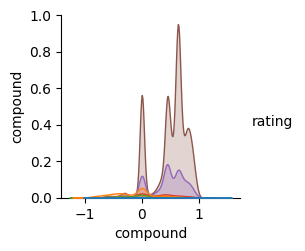

In [ ]:
sns.pairplot(data=kayak_nltk,
             vars=['compound'],
            hue='rating',
            palette='tab10')
plt.show()

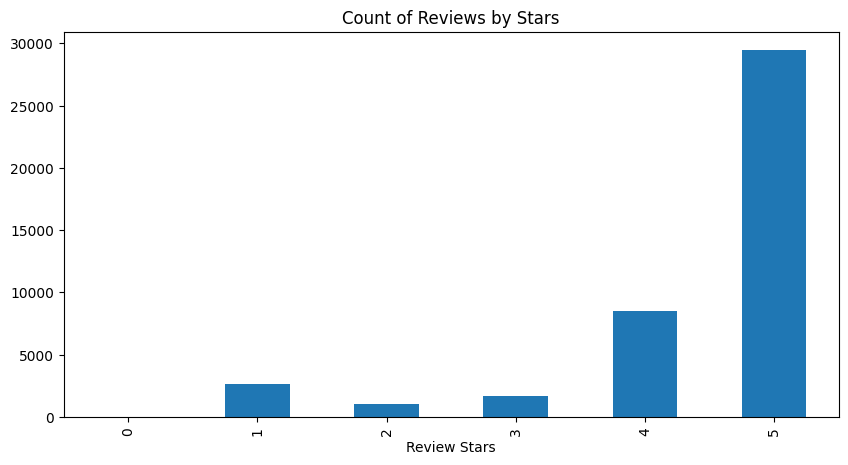

In [ ]:
ax = kayak_nltk['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()